## Setup

If executing in Colab: Before we start, we will select a GPU. 'Entorno de ejecución', 'Cambiar tipo de entrono de ejecución', 'Acelerador de hardware', '[GPU](https://medium.com/datadriveninvestor/comparing-gpu-and-tpu-training-performance-on-google-colaboratory-c1e54e26993f)'.

### Necessary libraries and paths

In [0]:
from fastai.text import * 
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

In [ ]:
import unicodedata
import pandas as pd

In [0]:
SAMPLE = True
PATH = Path('./sample') if SAMPLE else Path('.')
PATH.mkdir(exist_ok=True)

In [0]:
MODELS_PATH = PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

### Connect with Google Drive to download necessary files

In [ ]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive as storage
storage.mount('/content/gdrive')

### Download training and test set

In [0]:
!mkdir models

In [0]:
download = drive.CreateFile({'id': '1_0Kgr-2Hfywiaq4b-OE0YLblVnnv0QL_'})
download.GetContentFile(MODELS_PATH/'lm_enc.pth')

In [0]:
download = drive.CreateFile({'id': '1SSZ01bjf8_8xLboEBP2AFGTG5vslMpX2'})
download.GetContentFile(PATH/'vocab_lm.pkl')

## Preprocess training

In [0]:
df = pd.read_csv('train_pr.csv')
df.head()

,title,label_quality,language,category
0,pelicula vidro asus zenfone,reliable,portuguese,CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS
1,touch multilaser ms,reliable,portuguese,CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS
2,pelicula gel samsung pro celular top tela curva,reliable,portuguese,CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS
3,lcd frontal touch screen lente vidro samsung,reliable,portuguese,CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS
4,display lcd touch screen moldura lg,reliable,portuguese,CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS


In [ ]:
#shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.iloc[:200,:]
df.describe()

In [0]:
df.groupby('category').count().describe()

,title,label_quality,language
count,1576.000000,1576.000000,1576.000000
mean,1947.758249,1947.758249,1947.758249
std,560.922050,560.922050,560.922050
min,20.000000,20.000000,20.000000
25%,2199.000000,2199.000000,2199.000000
50%,2200.000000,2200.000000,2200.000000
75%,2200.000000,2200.000000,2200.000000
max,2200.000000,2200.000000,2200.000000


In [0]:
df.head()

,title,label_quality,language,category
0,prisma telescopio telescopio orig,unreliable,portuguese,TELESCOPES
1,colchonete roupa preta cobertor,unreliable,portuguese,EXERCISE_MATS
2,furador jumbo papel unicornio toke crie,unreliable,portuguese,HOLE_PUNCHES
3,tatame tapete eva bebe ginastica,unreliable,portuguese,EXERCISE_MATS
4,prancha salon line bellatrix bivolt,unreliable,portuguese,HAIR_STRAIGHTENERS


In [0]:
df.to_csv(PATH / 'train_preproPR.csv', index=False)

In [0]:
#check most frequent words
from collections import Counter 
Counter(" ".join(df["title"]).split()).most_common(250)

[('porta', 63617),
 ('frete', 57803),
 ('caixa', 52428),
 ('pecas', 51259),
 ('mesa', 46987),
 ('led', 46651),
 ('inox', 45090),
 ('infantil', 42471),
 ('capa', 40910),
 ('suporte', 40414),
 ('digital', 37499),
 ('aco', 36263),
 ('motor', 35611),
 ('bateria', 35526),
 ('cabo', 35454),
 ('jogo', 34998),
 ('madeira', 34548),
 ('preta', 31195),
 ('vidro', 30747),
 ('par', 30454),
 ('bomba', 30422),
 ('usb', 30313),
 ('maquina', 29907),
 ('aluminio', 29438),
 ('pro', 29012),
 ('pcs', 28547),
 ('tampa', 27383),
 ('protetor', 25594),
 ('eletrica', 24833),
 ('super', 24728),
 ('filtro', 24658),
 ('placa', 24620),
 ('notebook', 24348),
 ('fio', 24184),
 ('piscina', 23551),
 ('conjunto', 23494),
 ('freio', 23014),
 ('sensor', 22883),
 ('tv', 22588),
 ('controle', 22447),
 ('branca', 21928),
 ('agua', 21877),
 ('eletrico', 21834),
 ('bola', 21797),
 ('portatil', 21523),
 ('honda', 21487),
 ('bebe', 21397),
 ('bolsa', 21299),
 ('brinde', 20958),
 ('completo', 20709),
 ('camera', 20708),
 ('bivolt

## Classification

### Classification data

In [0]:
df_smp = pd.read_csv(PATH / 'train_preproPR.csv')

Now we create our 'databunch': an object that contains our datasets (train and validation) and our dataloaders. The dataloaders are iterables that we use to feed our model with batches of size 'batch_size'.

We must make sure that we use the same vocabulary (recongnized tokens) that we used in the language model. This will assure us that the model understands words and converts them to tokens in the same way.

In [0]:
 with open(PATH/'vocab_lm.pkl', "rb") as input_file:
    lm_vocab = pkl.load(input_file)

In [0]:
if not (PATH / 'data_clas_exportPR.pkl').exists() or True:
    data_clas = TextClasDataBunch.from_csv(
        PATH, 
        'train_preproPR.csv', 
        vocab=lm_vocab, 
        bs=800, 
        text_cols='title', 
        label_cols='category'
    )
    
    data_clas.save('data_clas_exportPR.pkl')
else:
    data_clas = load_data(PATH, 'data_clas_exportPR.pkl')

In [0]:
data_clas.show_batch(rows=10)

text,target
xxbos lona ripstop bege impermeavel sombra multi uso shade mt protecao sol chuva vento tenda tela toldo garagem carro,SHADE_CLOTHS
xxbos roda aro veneto civic fusion sonata azera creta equinox tucson hr et diamantado vittoria,AUTOMOTIVE_TIRES
xxbos glister creme dental sabao po sa amway ajuda fortalecer esmalte dente produto concentrado,TOOTHPASTES
xxbos xxunk xxunk ip hd mp cmos poe noite dia tv ip wi tre,IP_TELEPHONES
xxbos camarao artificial jig head brilha escuro robalo xxunk corvina xxunk xxunk tucunare traira,FISHING_LURES
xxbos tampa xperia aqua traseira fundo frete qualquer lugar leia logo abaixo descricao anuncio,CELLPHONE_AND_TABLET_CASES
xxbos cinta lombar hastes flexiveis protege coluna peso masculina feminina compressao verifique medidas anuncio,LUMBAR_AND_ABDOMINAL_BRACES
xxbos mesa tosa fixa prateleira pet mix girafa contencao suporte maquina qualidade top,GROOMING_TABLES
xxbos alicate eletricista descascador fios cabos ajustavel brinde chave teste tensao ac dc,WIRE_STRIPPERS
xxbos capa pet automotiva impermeavel protetora assento banco transportar carro cinto seguranca cachorro,DOG_CARRIERS_AND_CARRYING_BAGS


In [0]:
data_clas.save('data_clas_smpPR.pkl')

In [0]:
data_clas = load_data(PATH,'data_clas_smpPR.pkl')

### Classifier training

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.13, bptt=12, path=PATH)
learn.load_encoder('lm_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-01
Min loss divided by 10: 3.02E-02


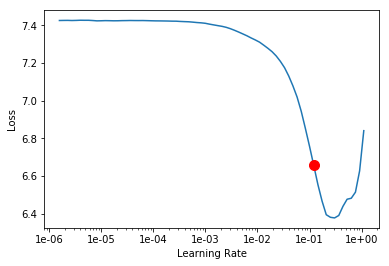

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [0]:
learn.fit_one_cycle(1, 9.5e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.969194,0.829876,0.823297,09:11


In [0]:
learn.save('class_fit_headPR')

In [0]:
learn.freeze_to(-2)

In [0]:
learn.fit_one_cycle(1, slice(9.5e-3/(2.6), 9.5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.771908,0.670642,0.852541,11:15


In [0]:
learn.save('class_fit_top2PR')

In [0]:
learn.load('class_fit_top2PR');

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()
# learn.recorder.plot(skip_end=20, skip_start=20, suggestion=True)

In [ ]:
learn.fit_one_cycle(
    3, slice(9.5e-4/(2.6), 9.5e-4), moms=(0.8, 0.7), 
    #callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='class_fit_full'), PrintingCallback()]
)

In [0]:
learn.save('class_fit_fullPR')

## Make submission

### Validation Balanced Accuracy

In [0]:
from sklearn.metrics import balanced_accuracy_score

probs = learn.get_preds(ds_type=DatasetType.Valid)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

In [0]:
true = [data_clas.classes[i] for i in probs[1].detach().numpy()]

Note: here we are calculating the balanced accuracy over both *reliable* and *unreliable* items, but the test set only contains *reliable* items.


In [0]:
balanced_accuracy_score(true, preds_clas)

### Generate Submission

In [0]:
df = pd.read_csv('test_clean.csv')

In [0]:
df.pop('language');
df.pop('id');

In [0]:
df.head()

In [0]:
learn.data.add_test(df, label=None)

In [0]:
learn.data.show_batch(ds_type=DatasetType.Test, rows=10)

In [0]:
probs = learn.get_preds(ds_type=DatasetType.Test)
pred_indices = torch.argmax(probs[0], dim=1)
preds_clas = [data_clas.classes[pred] for pred in pred_indices]

In [0]:
learn.data.test_ds[10], preds_clas[10]

((Text xxbos picadora carne fineschi legitima, EmptyLabel ), 'MEAT_GRINDERS')

In [0]:
learn.data.test_ds[100], preds_clas[100]

((Text xxbos gorras tycel claritos perforar puro latex, EmptyLabel ),
 'HAIRDRESSING_CAPS')

In [0]:
learn.data.test_ds[1000], preds_clas[1000]

((Text xxbos cepillo planchita alisador peine electrico, EmptyLabel ),
 'HAIR_STRAIGHTENING_BRUSHES')

In [0]:
df = pd.read_csv('test_clean_2.csv')
#df.pop('language');
#df.pop('title');
df['category'] = preds_clas

In [0]:
df.head(5)

In [0]:
df.to_csv('submission_PR.csv', index=False)